In [1]:
import datetime
from nowtrade.symbol_list import StockList
from nowtrade.data_connection import MongoDatabaseConnection
from nowtrade import dataset 
from nowtrade import technical_indicator
from nowtrade import criteria
from nowtrade import criteria_group
from nowtrade import trading_profile
from nowtrade import trading_amount
from nowtrade import trading_fee
from nowtrade import strategy
from nowtrade import neural_network
from nowtrade.action import Long
from nowtrade.action import Short
from nowtrade.action import LongExit
from nowtrade.action import ShortExit

In [2]:
#dc= data_connection.MongoDatabaseConnection()

In [3]:
sl=StockList(['GOOGL'])

In [4]:
symbol= sl.get('GOOGL')

In [5]:
train_start = datetime.datetime(2013, 01, 03)
train_end = datetime.datetime(2016,01, 01)
train_dataset = dataset.Dataset(sl, MongoDatabaseConnection(), train_start, train_end)
#train_dataset=dc.get_data(symbol,train_start,train_end)

In [6]:
train_dataset.load_data()

In [7]:
train_dataset.data_frame.columns

Index([u'GOOGL_Close', u'GOOGL_High', u'GOOGL_Low', u'GOOGL_Open',
       u'GOOGL_Volume'],
      dtype='object')

In [8]:
train_dataset.data_frame.head()

,GOOGL_Close,GOOGL_High,GOOGL_Low,GOOGL_Open,GOOGL_Volume
Date,,,,,
2013-01-03,362.20,366.33,360.72,362.83,2318140.0
2013-01-04,369.35,371.11,364.20,365.03,2763552.0
2013-01-07,367.74,370.06,365.66,368.09,1655967.0
2013-01-08,367.02,368.52,362.58,368.14,1676740.0
2013-01-09,369.43,369.54,364.66,366.50,2025751.0


In [9]:
#nn = neural_network.NeuralNetwork([symbol.open, symbol.high, symbol.low, symbol.close, symbol.volume], [symbol.close])
nn = neural_network.NeuralNetwork([symbol.open, symbol.high, symbol.low, symbol.close, symbol.volume], [symbol.close])

In [10]:
nn.build_network(train_dataset, hidden_layers=3, prediction_window=1, learning_rate=0.001, momentum=0.1)

In [11]:
train_intervals= 10

In [12]:
nn.train_data

['GOOGL_Open', 'GOOGL_High', 'GOOGL_Low', 'GOOGL_Close', 'GOOGL_Volume']

In [13]:
for i in range(train_intervals): nn.train()

Total error: 2.80190781878
Total error: 0.0333273971287
Total error: 0.0155527166898
Total error: 0.0154602989559
Total error: 0.0154414353166
Total error: 0.0154510029118
Total error: 0.0154196941457
Total error: 0.0154564493573
Total error: 0.0154522378239
Total error: 0.0154470953958


In [14]:
nn.save_to_file('test.nn')

In [15]:
nn = neural_network.load_from_file('test.nn')

In [16]:
test_start = train_end
test_end = datetime.datetime(2017, 04, 15)
test_dataset = dataset.Dataset(sl, MongoDatabaseConnection(), test_start, test_end)

In [17]:
test_dataset.load_data()

In [18]:
neural_network = technical_indicator.NeuralNetwork(nn)

In [19]:
test_dataset.add_technical_indicator(neural_network)

In [20]:
threshold_above = technical_indicator.Addition(neural_network.value, 5)

In [21]:
test_dataset.add_technical_indicator(threshold_above)

In [22]:
threshold_below = technical_indicator.Subtraction(neural_network.value, 5)
test_dataset.add_technical_indicator(threshold_below)

In [23]:
test_dataset.data_frame.head()

,GOOGL_Close,GOOGL_High,GOOGL_Low,GOOGL_Open,GOOGL_Volume,NEURAL_NETWORK_c529eda5-cea3-4431-b707-ba66fc1f2e8a,ADDITION_NEURAL_NETWORK_c529eda5-cea3-4431-b707-ba66fc1f2e8a_5,SUBTRACTION_NEURAL_NETWORK_c529eda5-cea3-4431-b707-ba66fc1f2e8a_5
Date,,,,,,,,
2016-01-04,759.44,762.20,747.54,762.20,3352912.0,534.158172,539.158172,529.158172
2016-01-05,761.53,769.20,755.65,764.10,2260795.0,534.158161,539.158161,529.158161
2016-01-06,759.33,765.73,748.00,750.37,2410301.0,534.158161,539.158161,529.158161
2016-01-07,741.00,755.31,735.28,746.49,3156563.0,534.158166,539.158166,529.158166
2016-01-08,730.91,750.12,728.92,747.80,2375348.0,534.158158,539.158158,529.158158


In [24]:
enter_crit_long = criteria.Below(symbol.close, threshold_below.value)

In [25]:
enter_crit_short = criteria.Above(symbol.close, threshold_above.value)

In [26]:
exit_crit_long = criteria.BarsSinceLong(symbol, 1)
exit_crit_short = criteria.BarsSinceShort(symbol, 1)

In [27]:
enter_crit_group1 = criteria_group.CriteriaGroup([enter_crit_long], Long(), symbol)
enter_crit_group2 = criteria_group.CriteriaGroup([enter_crit_short], Short(), symbol)
exit_crit_group1 = criteria_group.CriteriaGroup([exit_crit_long], LongExit(), symbol)
exit_crit_group2 = criteria_group.CriteriaGroup([exit_crit_short], ShortExit(), symbol)

In [28]:
tp = trading_profile.TradingProfile(100000, trading_amount.StaticAmount(10000), trading_fee.StaticFee(5))

In [29]:
test_dataset.data_frame.tail()

,GOOGL_Close,GOOGL_High,GOOGL_Low,GOOGL_Open,GOOGL_Volume,NEURAL_NETWORK_c529eda5-cea3-4431-b707-ba66fc1f2e8a,ADDITION_NEURAL_NETWORK_c529eda5-cea3-4431-b707-ba66fc1f2e8a_5,SUBTRACTION_NEURAL_NETWORK_c529eda5-cea3-4431-b707-ba66fc1f2e8a_5
Date,,,,,,,,
2017-04-07,842.10,845.88,837.30,845.00,1111610.0,534.158153,539.158153,529.158153
2017-04-10,841.70,846.74,840.79,841.54,1046215.0,534.158150,539.158150,529.158150
2017-04-11,839.88,844.63,834.60,841.70,974343.0,534.158148,539.158148,529.158148
2017-04-12,841.46,843.72,837.59,838.46,1135775.0,534.158152,539.158152,529.158152
2017-04-13,840.18,843.73,837.85,841.04,1073650.0,534.158151,539.158151,529.158151


In [30]:
%matplotlib inline
import matplotlib.pyplot as plt
from nowtrade.figures import Figure

/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:280: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '
/anaconda/lib/python2.7/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The finance module has been deprecated in mpl 2.0 and will be removed in mpl 2.2. Please use the module mpl_finance instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [31]:
#test_dataset.data_frame.plot()

In [32]:
strat = strategy.Strategy(test_dataset, [enter_crit_group1, enter_crit_group2, exit_crit_group1, exit_crit_group2], tp)

In [33]:
strat.simulate()

In [34]:
print strat.report.overview

<bound method Report.overview of <nowtrade.report.Report object at 0x7f8291071f90>>


In [35]:
#fig = Figure(test_dataset, rows=4)

In [36]:
#fig.add_chart('Date', 1) # First chart holds the googl candlesticks
#fig.add_chart('GOOGL_Volume', 2, 'bar') # Second chart holds the volume
#fig.add_chart('NEURAL_NETWORK_e6b1f791-8c5c-4d7a-9f34-4e7c1aaa6f8a', 3) # Third chart holds the simple moving averages
#fig.add_chart('ADDITION_NEURAL_NETWORK_e6b1f791-8c5c-4d7a-9f34-4e7c1aaa6f8a_5', 4, color='red') # SMA25 will have a red line
#fig.add_capital_chart(4) # Show the capital history on the last chart

In [37]:
#fig.show()

In [38]:
import matplotlib
matplotlib.style.use('ggplot')

In [39]:
#test_dataset.data_frame['Date']
n_net='NEURAL_NETWORK_'+neural_network.name

In [40]:
#plt.figure();
z=test_dataset.data_frame.loc[:,['GOOGL_Volume','GOOGL_Close',n_net]]


In [41]:
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
import numpy as np

In [42]:
mms=MinMaxScaler()

In [43]:
G_Close_min_max=mms.fit_transform(z['GOOGL_Close'])

/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


In [44]:
NN_Close_predict=mms.fit_transform(test_dataset.data_frame[n_net])

/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


In [45]:
import pandas as pd

In [46]:
z['NN_Predict']=test_dataset.data_frame[n_net]

In [47]:
z=z.drop(n_net,1)

In [48]:
#z=z.drop('Date',1)

In [49]:
zz=pd.DataFrame(mms.fit_transform(z))

In [50]:
zz.columns=z.columns

In [51]:
zz=zz.set_index(z.index)

In [52]:
zz.head()

,GOOGL_Volume,GOOGL_Close,NN_Predict
Date,,,
2016-01-04,0.430382,0.409455,0.745616
2016-01-05,0.258799,0.420384,0.588751
2016-01-06,0.282288,0.408879,0.598094
2016-01-07,0.399534,0.313026,0.673297
2016-01-08,0.276797,0.260263,0.548174


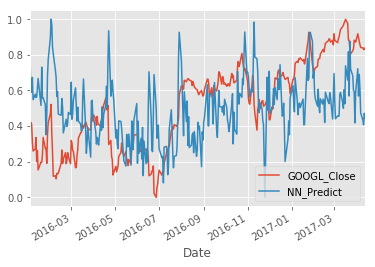

In [53]:
#df = df.rename(columns={'oldName1': 'newName1', 'oldName2': 'newName2'}
zz[['GOOGL_Close','NN_Predict']].plot()

In [54]:
zz.head()

,GOOGL_Volume,GOOGL_Close,NN_Predict
Date,,,
2016-01-04,0.430382,0.409455,0.745616
2016-01-05,0.258799,0.420384,0.588751
2016-01-06,0.282288,0.408879,0.598094
2016-01-07,0.399534,0.313026,0.673297
2016-01-08,0.276797,0.260263,0.548174


In [55]:
print strat.report.pretty_overview()

Trades:
GOOGL
Trade(datetime=2016-01-05 00:00:00, action=SHORT, symbol=GOOGL, price=764.1, shares=13.0, money=9933.3, fee=5, slippage=0.0)
Trade(datetime=2016-01-07 00:00:00, action=SHORT_EXIT, symbol=GOOGL, price=746.49, shares=13.0, money=9704.37, fee=5, slippage=0.0)
Trade(datetime=2016-01-08 00:00:00, action=SHORT, symbol=GOOGL, price=747.8, shares=13.0, money=9721.4, fee=5, slippage=0.0)
Trade(datetime=2016-01-12 00:00:00, action=SHORT_EXIT, symbol=GOOGL, price=740.75, shares=13.0, money=9629.75, fee=5, slippage=0.0)
Trade(datetime=2016-01-13 00:00:00, action=SHORT, symbol=GOOGL, price=749.34, shares=13.0, money=9741.42, fee=5, slippage=0.0)
Trade(datetime=2016-01-15 00:00:00, action=SHORT_EXIT, symbol=GOOGL, price=709.99, shares=13.0, money=9229.87, fee=5, slippage=0.0)
Trade(datetime=2016-01-19 00:00:00, action=SHORT, symbol=GOOGL, price=720.15, shares=14.0, money=10082.1, fee=5, slippage=0.0)
Trade(datetime=2016-01-21 00:00:00, action=SHORT_EXIT, symbol=GOOGL, price=720.17, sha